# Finding Optimal Delivery Centre Location

### Import libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import time
import random
from scipy.stats import f_oneway

In [2]:
AVERAGE_SPEED = 15/3.6
PREP_TIME_PER_PARCEL = 50
RETURN_TIME_PER_PARCEL = 30
AVERAGE_TIME_ANSWER_DOOR = 40
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

Operational cost is 8c/km

In [3]:
OPERATIONAL_COST_BIKE = 0.08

Payment to driver is 30 euros per hour, with minimum of 60 euros pepr day

In [4]:
DRIVER_PAYMENT = 30
MINIMUM_DRIVER_PAYMENT = 60

### Plot map (as before)

In [5]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=9,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [i for (i, j) in W], [j for (i, j) in W], 
                      styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8*maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

## Time Handling
**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.
`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [6]:
def timestamp(t):
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(math.floor(t))
    t = int(math.floor((t - secs)*10))
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [7]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.0'

In [8]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [9]:
def day(now):
    return int(now//(24*3600))

## Plotting Routines

In [10]:
import scipy.stats as stats


def histplot(data, title="", xlabel="",
             width=None, height=None):
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)

    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()

    hist = plt.hist(data, density=True)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)

    x = np.linspace(minx, maxx, 100)
    y = [stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy,
            f'μ={μ:2.2f}\nσ={σ:2.2f}',
            ha='right', va='top',
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

In [11]:
def dailyPlot(data,
              title="", ylabel="",
              width=None, height=None):
    days = len(data)

    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)

    ax = fig.gca()
    diff = (max(data) - min(data)) * 0.1
    ymin = int(math.floor(min(data) - diff))
    ymax = int(math.ceil(max(data) + diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    ms = 2 if len(data) > 100 else 5
    lw = 0.5 if len(data) > 100 else 1

    x = np.arange(0, len(data))
    y = np.array([y for y in data])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)

    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m * x + b, 'r-')

    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Class Recorder

We will use a class Recorder as a reference point for capturing data during the simulation.There will be only one recorder.It will be created at the beginning of every simulation run.Every entity will carry a reference to the Recorder.

In [12]:
class Recorder:

    def __init__(self, env, M, W, C, days,
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot

        self.timing = timing
        self.start_time = time.time()
        self.last_time = self.start_time
        self.cum_timer = {}

        Customer.REGISTER = []
        Parcel.REGISTER = []

        # create a data frame for records per working day
        self.daily = pd.DataFrame()
        self.daily['begin work at'] = [None] * days
        self.daily['end work at'] = [None] * days
        self.daily['dist'] = [None] * days
        self.daily['left'] = [None] * days

    def timer(self, s):
        t = time.time()
        Δt = t - self.last_time
        if self.timing:
            print(f"==== t: {t - self.start_time:6.2f}s "
                  f"Δt: {Δt:6.2f}s [{s:s}]")
        if s in self.cum_timer:
            self.cum_timer[s] += Δt
        else:
            self.cum_timer[s] = Δt
        self.last_time = t

    def reportTimer(self):
        print(f"==== t: {self.total_time:6.2f}s Total")
        for k in sorted(self.cum_timer, key=lambda x: self.cum_timer[x], reverse=True):
            print(f"==== ΣΔt: {self.cum_timer[k]:6.2f}s " + k)

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin work at'] = int(round(self.env.now))

    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end work at'] = int(round(self.env.now))

    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def finish(self):
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None
        self.total_time = time.time() - self.start_time
        self.daily['working time'] = (self.daily['end work at'] - self.daily['begin work at']) // 60

    def __stats__(self, column):
        d = self.daily[column].copy()
        return d.mean(), d.median(), d.std()

    def statsWorkingTime(self):
        return self.__stats__('working time')

    def histWorkingTime(self):
        histplot(self.daily['working time'],
                 xlabel='Working Time [min]',
                 title='Daily Working Time')

    def plotWorkingTime(self):
        dailyPlot(self.daily['working time'],
                  ylabel='Working Time [min]',
                  title='Daily Working Time')

    def statsTourLength(self):
        return self.__stats__('dist')

    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')

    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')

    def statsLeftOver(self):
        return self.__stats__('left')

    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')

    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')

In [13]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust, custIndex):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.custIndex = custIndex
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location, custIndex):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location, custIndex)

    
    def __str__(self):
        return f"Parcel: {self.i:3d} ({self.custIndex:3d})"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
    

In [14]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

### Load Map data

In [15]:
with open('data.pickled', 'rb') as f:
    M, C = pickle.load(f)

### Load warehouse data

In [16]:
with open('warehouseData.pickle', 'rb') as f:
    W = pickle.load(f)

### Load Records data

In [17]:
with open('records.pickle', 'rb') as f:
    rec = pickle.load(f)

### Plotting maps

Raw Map


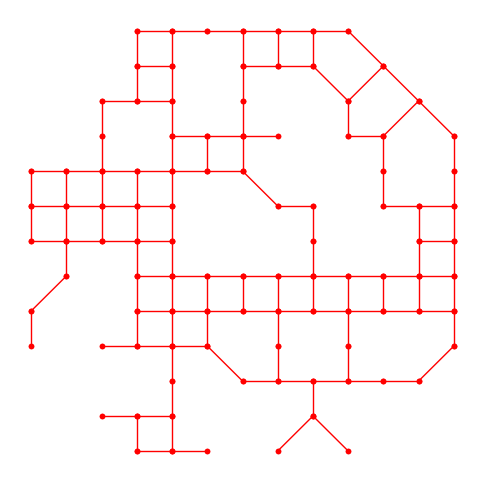

In [18]:
print("Raw Map")
plotMap(M)

Customer locations


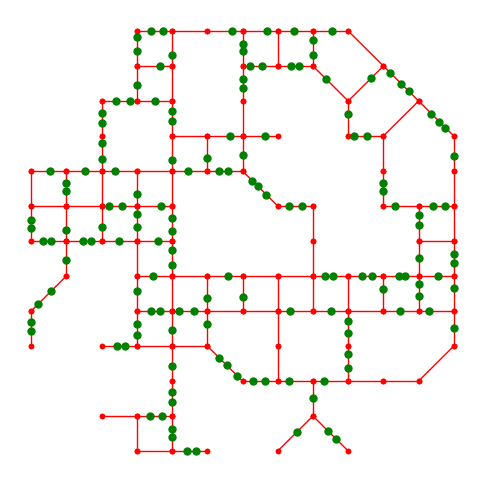

In [19]:
print("Customer locations")
plotMap(M, T=C)

Candidate Warehouse locations


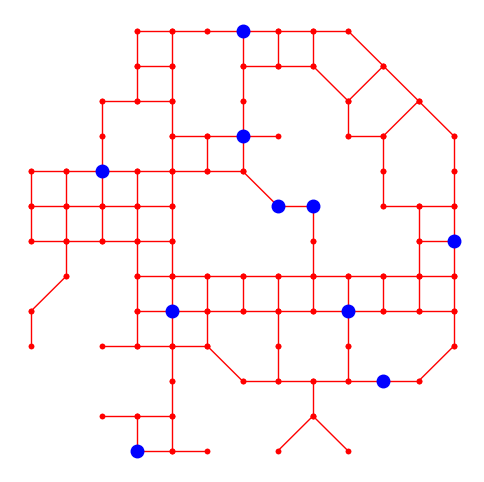

In [20]:
print("Candidate Warehouse locations")
plotMap(M, W=W)

Map with all customers and candidate Warehouses


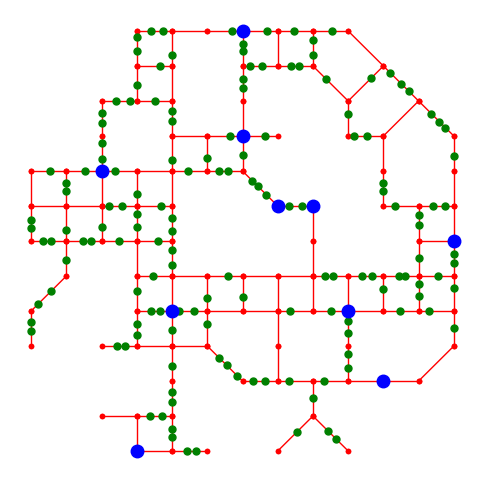

In [21]:
print("Map with all customers and candidate Warehouses")
plotMap(M, T=C, W=W)

In [22]:
def calculate_operational_cost(R: Recorder):
    average_working_time = R.statsWorkingTime()[0]
    driver_cost = average_working_time * DRIVER_PAYMENT / 60
    driver_cost = max(driver_cost, MINIMUM_DRIVER_PAYMENT)
    
    distance_travelled = R.statsTourLength()[0]
    bike_cost = distance_travelled * OPERATIONAL_COST_BIKE / 1000
    
    total_cost = driver_cost + bike_cost
    return total_cost

In [23]:
def plot_costs(costs):
    plt.plot(costs)
    plt.xlabel("Warehouse")
    plt.ylabel("Average operational cost (in €)")
    plt.show()

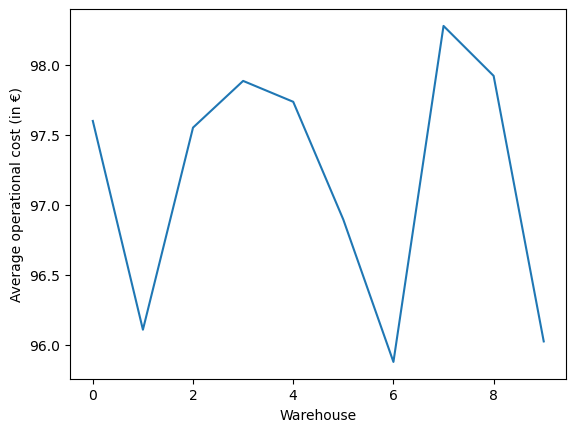

In [24]:
costs = []
for i in range(len(W)):
    cost = calculate_operational_cost(rec[i])
    costs.append(cost)
plot_costs(costs)

In [25]:
def plot_map_best_location(costs):
    minm = min(costs)
    min_i = costs.index(minm)
    
    print(f"The optimal warehouse is at {W[min_i]} with €{round(costs[min_i], 2)} average operational cost per day")
    
    plotMap(M, T=C, W=[W[min_i]])

The optimal warehouse is at (4000, 7360) with €95.88 average operational cost per day


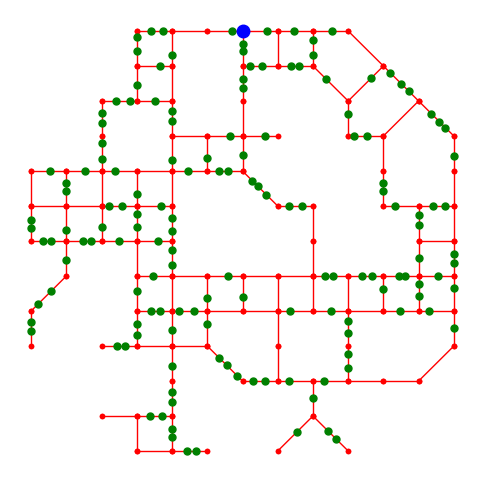

In [26]:
plot_map_best_location(costs)

In [27]:
print("Mean Cost:", np.mean(costs))
print("Median Cost:", np.median(costs))
print("Max Cost:", np.max(costs))
print("Min Cost:", np.min(costs))
print("Std Dev:", np.std(costs))

Mean Cost: 97.18724914285715
Median Cost: 97.57474285714287
Max Cost: 98.27661714285715
Min Cost: 95.87867428571428
Std Dev: 0.844014808869791


In [28]:
costs = []
for i in range(len(rec)):
    d = rec[i].daily['dist']
    t = rec[i].daily['working time']
    cost = []
    for j in range(len(d)):
        c = d[j] * OPERATIONAL_COST_BIKE / 1000
        pc = t[j] * DRIVER_PAYMENT / 60
        pc = max(pc, MINIMUM_DRIVER_PAYMENT)
        c += pc
        cost.append(c)
    costs.append(cost)

# ANOVA test
f_statistic, p_value = f_oneway(costs[0], costs[1], costs[2], costs[3], costs[4], costs[4], costs[5], costs[6], costs[7], costs[8], costs[9])

print("F-statistic:", f_statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("There is statistical significance")
else:
    print("No statistical significance")

F-statistic: 0.16908932363432988
P-value: 0.9978229519103938
No statistical significance
